In [291]:
# -*- encoding: utf-8 -*-
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [292]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import numpy as np
from collections import Counter,OrderedDict
import MeCab
import re
import json

In [293]:
# 可视化
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

In [294]:
#模型保存与载入
from sklearn.externals import joblib
# # 注释语句用来存储你的模型
# joblib.dump(km,  'doc_cluster.pkl')
# km = joblib.load('doc_cluster.pkl')

In [295]:
# 可视化
def clusterPlotTNSE(data,tag):
    # PCA降维
    reduced = TruncatedSVD(n_components=32).fit_transform(data)
    # TSNE降维
    embedded = TSNE(n_components=2, perplexity=30).fit_transform(reduced)
    #TSNE可视化
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.title('Comment DataSet  with TSNE')
    plt.scatter(embedded[:, 0], embedded[:, 1],c=tag, marker="x")
    

In [296]:
# 获取训练数据
def getTrainSet(inFile):
    # 文章标题集
    title_set = []
    # 训练集
    train_set=[]
    # 读入训练数据
    f=open(inFile)
    lines=f.readlines()
    for line in lines:
        article = line.replace('\n','').split('\t')
        title = article[0]
        title_set.append(title)
        content = article[1]
        train_set.append(content)
    f.close()
    return (title_set,train_set)

In [297]:
# 读取停用词一览
def readStopWord(ssfile):
    ss = []
    fr = open(ssfile,"r")
    for line in fr.readlines():
        line = line.strip()
        if line != '':
            ss.append(line)
    fr.close()
    return ss

In [298]:
def getClusterInfo(clusterNum,labels,info):
    print "cluster %s length =%s" % (clusterNum,len(info[labels== clusterNum]))
    result = []
    for i in info[labels==clusterNum]:
#         print "cluster %s : %s " % (clusterNum,i)
        result.append(i)
    return result

In [299]:
# 获取词汇本体
def get_surfaces(node):
    words = []
    nouns = []
    while node:
        word  = node.surface
        words.append(word)
        noun = node.feature.split(",")[0]
        nouns.append(noun)
        node = node.next
    return words,nouns

In [300]:
# 利用词性筛选词汇
def select_feature(data,attr):
    result = []
    pattern1 = re.compile(r'[^0-9]+')
    pattern2 = re.compile(ur'[^０１２３４５６７８９]+')
    pattern3 = re.compile(ur'[^\[\]!$%&\'\"\(\):\-\.,/;=<>]+')
    pattern4 = re.compile(ur'[^！　％、。）※「」（＞～』＜？－．♪【⇒∞★〇・⇔]+')
    for (w,a) in data:
        if a in attr:
#             print w,a
            # 过滤所有数字
            tmp = w.decode('utf-8')
            matcher1 = re.match(pattern1,w)
            matcher2 = re.match(pattern2,tmp)
            matcher3 = re.match(pattern3,tmp)
            matcher4 = re.match(pattern4,tmp)
            if (matcher1 is not None) and (matcher2 is not None) and (matcher3 is not None) and (matcher4 is not None):
#                 print w,a
                result.append((w,a))
    return result

In [301]:
def callMecab(text):    
    # 定义分词器
    
    ssfile = "./conf/Japanese_stopwords.txt"
    ssList = readStopWord(ssfile)
    
    mt = MeCab.Tagger('mecabrc')
    node = mt.parseToNode(text)
    words, nouns = get_surfaces(node)
    wordList = zip(words,nouns)
    
    attr = [u'名詞',u'形容詞']
    selectList = select_feature(wordList,attr)
    
    return_word = []
    # 去掉停用词
    for (w,a) in selectList:
        if w not in ssList:
            return_word.append(w)
        
    return return_word

In [302]:
# from collections import Counter,OrderedDict
# Count结果，然后写入JSON文件
# 抽取计数前 top_n
def writeCountJSON(fileName,data,top_n = 10,sort=False,itemFilter=False,filterSet=None):    
    
    jsonFile = fileName + ".json"
    wd_pic = fileName + ".png"
    
    count = Counter(data)
    tmp = count.most_common(top_n)
    # 排序
    if sort :
        print " * dictionary sorted * "
        out = OrderedDict(sorted(tmp, key=lambda item:int(item[1]), reverse=True))
    else:
        out = dict(tmp)
    # 过滤元素
    if itemFilter:
        if filterSet is not None:
            for f in out.keys():
                if f in filterSet:
                    out.pop(f)
    
    # wordcloud只能接受unicode的字符，需要先把字符从utf-8转化为unicode 
    wd = {}
    for k in out.keys():
        wd[k.decode('utf-8')] = out[k]
    # 创建词云
    plotWordCloud(wd,wd_pic)
    
    # 写入JSON
    with open(jsonFile, 'w') as json_file:
        json_file.write(json.dumps(out,sort_keys=False,indent=4, ensure_ascii=False))

In [303]:
from wordcloud import WordCloud 
def plotWordCloud(text,pic):
    wc = WordCloud(font_path='./font/ipag.ttf',#设置字体  
                background_color="white", #背景颜色  
                max_words=200,# 词云显示的最大词数  
                max_font_size=100, #字体最大值  
                random_state=42,
                scale = 2 
                ) 
    my_wordcloud = wc.generate_from_frequencies(text)
    #显示词云图  
    plt.imshow(my_wordcloud)  
    #是否显示x轴、y轴下标  
    plt.axis("off")  
    plt.show()
    wc.to_file(pic) #保存图片

In [304]:
def trainModel(dataSet,text,cluster_num=5):
    
    i,c = text
    info = np.array(i)
    comment = np.array(c)    
    
    # PCA降维
    reduced_data = PCA(n_components=2).fit_transform(dataSet)
    x_loc = np.array([n[0] for n in reduced_data])
    y_loc = np.array([n[1] for n in reduced_data])
    
    # 用PCA对原始数据降维后做kmeans    
    clf = KMeans(init='k-means++',n_clusters=cluster_num,n_init=10) 

    clf.fit(dataSet)
    
    # 聚类标签
    labels = clf.labels_

    # 获得第一类聚类结果的文本内容
    label = Counter(labels)
    
#     p1 = plt.subplot(111)  
    plt.title("Kmeans n=5")  
    
#     plt.scatter(x_loc,y_loc,c=clf.labels_.tolist(),marker="x",label=clf.labels_.tolist())  
#     plt.show()
    
  
    #四种颜色 红 绿 蓝 黑    
    plot1, = plt.plot(x_loc[labels==0],y_loc[labels==0], 'or', marker="x")    
    plot2, = plt.plot(x_loc[labels==1],y_loc[labels==1], 'og', marker="o")    
    plot3, = plt.plot(x_loc[labels==2],y_loc[labels==2], 'ob', marker="*")   
    plot4, = plt.plot(x_loc[labels==3],y_loc[labels==3], 'oy', marker="<")  
    plot5, = plt.plot(x_loc[labels==4],y_loc[labels==4], 'oc', marker="^")  

    #设置右上角图例  
    plt.legend((plot1, plot2, plot3,plot4, plot5), 
               ('cluster1', 'cluster2', 'cluster3','cluster4','cluster5'), fontsize=10)  

    plt.show()
#     plt.sca(p1) 
       
    # TNSE可视化
#     clusterPlotTNSE(dataSet,clf.labels_) 
    

    print label
    outPath = "./data/"
    filterList = [u"AIU",u"事故",u"保険料",u"対応",u"補償内容",u"車",u"保険",u"代理店",u"損保",u"補償",
              u"アクサ",u"契約",u"連絡",u"アクサダイレクト",u"イーデザイン",u"電話",u"保険会社",
              u"ニッセイ",u"ダイレクト",u"三井",u"サービス",u"三井住友海上",u"ジャパン",u"日新火災",
              u"加入",u"セゾン",u"チューリッヒ",u"担当者",u"担当",u"必要",u"会社",u"内容",u"車両保険",
             u"自動車保険",u"インターネット",u"ネット"]
    for k in label.keys():
        # 获取cluster的内容
        content = getClusterInfo(int(k),clf.labels_,comment)
        # 获取分词结果
        outWord = []
        for text in content:
            split_word = callMecab(text)
            outWord.extend(split_word)            
        fname = outPath + "cluster_" + str(k)
        writeCountJSON(fname,outWord,top_n=80,sort=True,itemFilter=True,filterSet=filterList)
    
#     joblib.dump(tfidf_vectorizer, 'tfidf_fit_result.pkl')
#     joblib.dump(km_cluster, 'km_cluster_fit_result.pkl')

    #程序下一次则可以直接load
#     tfidf_vectorizer = joblib.load('tfidf_fit_result.pkl')
#     km_cluster = joblib.load('km_cluster_fit_result.pkl')

 

In [305]:
def main():
    
    tfidfData = "./model/textData_TFIDF.npy"
    lsiData = "./model/textData_LSI.npy"
    ldaData = "./model/textData_LDA.npy"
    
    inFile = "./data/processed/all_merge.txt"    
    
    # 读入数据 原数据矩阵需要做转置
    tfidfDataSet = np.load(tfidfData).T
        
    lsiDataSet = np.load(lsiData).T
    
    ldaDataSet = np.load(ldaData).T
    
    # 训练数据
    print "TFIDF data Clustering"
    trainModel(tfidfDataSet,getTrainSet(inFile),5)

#     trainModel(ldaDataSet,5)
      
    

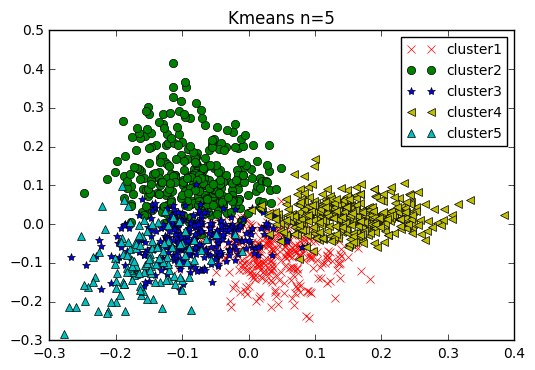

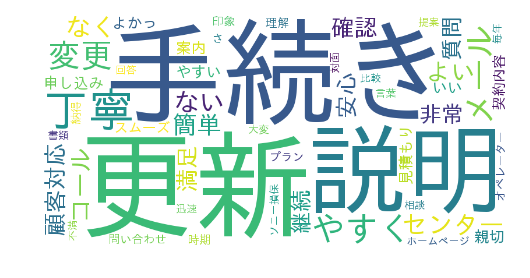

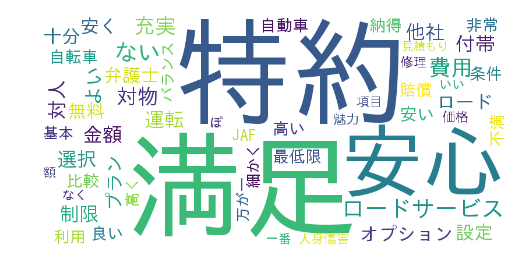

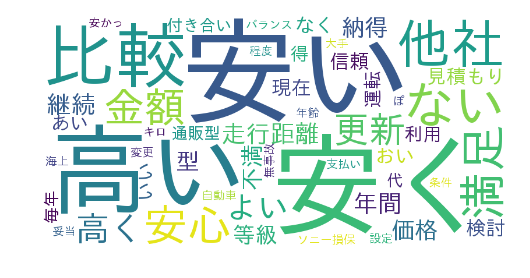

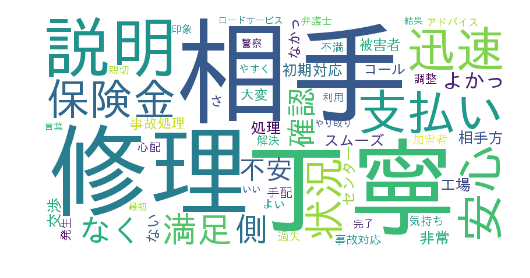

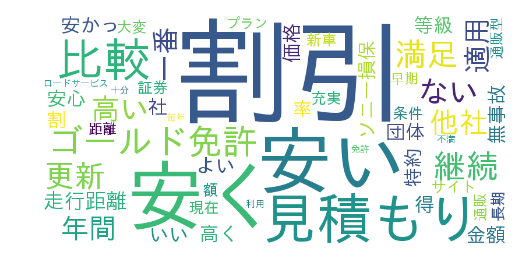

In [306]:
if __name__ == '__main__':
    main()